In [1]:
#hide
from neuralThompsonTrainer.core import *

# Project name here

> Summary description here.

Given a Neural Network, we use Thompson Sampling to find an optimal configuration of sub-networks that best predicts the target function. 

Three steps:
1. build a neural Network that allows for 'attention', i.e. external dropout; generate a target function from that Network by randomly sampling a hidden attention vector. The goal of optimizing the network on the target data becomes a question of recovering the hidden attention vector.
2. Train a Thompson Sampling Solver to experiment with different Network configurations, update the sampler on the error the network produces.
3. wait for convergence; Note that the network itself remains unchanged wrgt it's parameters, only the TS learns how to optimize given the error.


The given example is trivial in that it uses a single hidden attention vector; and in that we sample the target function from subnetworks of the predictive Network; We also use no contextual information whatsoever. It's a Proof of concept, however, that might be expanded into a nonlinear contextual attention sampler that prodcues 'good enough' predictions without having to train a neural network (or by training the network via Gradient Descent after finding distribution over subsampled networks).


## Install

`pip install your_project_name`

## How to use

Fill me in please! Don't forget code examples:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize' ]= 16,9


Bad key "text.kerning_factor" on line 4 in
/home/thomas/anaconda3/envs/pytorch_GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:

from neuralThompsonTrainer.neural_networks import NeuralNetwork, DenseLayer, DropoutLayer, AttentionDropoutLayer


from neuralThompsonTrainer.thompson_sampler import GaussianBandit


In [4]:
np.random.seed(4)

num_units = 4

# Initialise the Network, sample a hidden attention vector, produce target function

## initialize the Model

as we can see, it's a model with num_units neurons in two attention dropout layers and two dense layers

In [5]:
model = NeuralNetwork(loss='mean-square-error',randomMultiplier=1)

model.addLayer(inputDimension=1, units=10, activation='tanh')#,layer_type = DropoutLayer)
model.addLayer( units=num_units, activation='tanh')
model.addLayer( units=1, activation='tanh',layer_type = AttentionDropoutLayer)
model.addLayer( units=num_units, activation='tanh')
model.addLayer( units=1, activation='',layer_type = AttentionDropoutLayer)
model



[
  1 -> Dense layer (nx=1, nh=10, activation=tanh)
  2 -> Dense layer (nx=10, nh=4, activation=tanh)
  3 -> Attention Dropout layer (nx=4, nh=1, activation=tanh)
  4 -> Dense layer (nx=1, nh=4, activation=tanh)
  5 -> Attention Dropout layer (nx=4, nh=1, activation=none)
]

## Sample hidden attention from binomial distribution of size weights matrix

In [6]:
X = np.atleast_2d(np.linspace(-1,1,100))
attention = np.ones(model.layers[2].weights.shape)

dropout_percent = 0.5

attention = np.random.binomial([np.ones((model.layers[2].weights.shape))],1-dropout_percent)[0]#.shape
attention

full_attention = np.ones(model.layers[2].weights.shape)


## Generate the truth function from neural network by using a predefined attention

In [7]:
yhat = []

for x in X.T:
    yhat += [model.forward(np.atleast_2d(x), attention)]

yhat = np.array(yhat)




What the neural network is initialized to show:


In [8]:

yhat_full = []

for x in X.T:
    yhat_full += [model.forward(np.atleast_2d(x), full_attention)]

yhat_full = np.array(yhat_full)

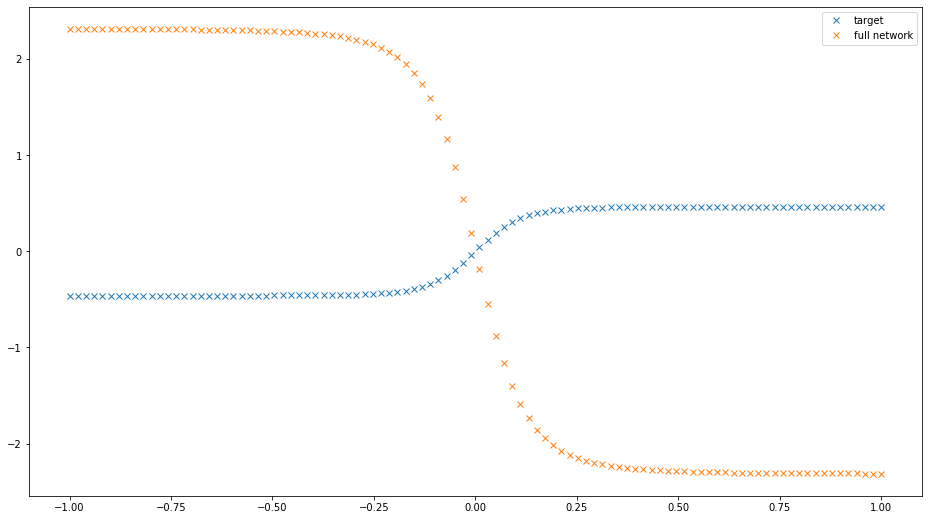

In [9]:
plt.plot(X.squeeze(), yhat.squeeze(),'x',label='target')
plt.plot(X.squeeze(), yhat_full.squeeze(),'x',label='full network')
plt.legend()

# Define Attentional TS (ToDo: move to package)

In [10]:
class IndependentAttentionTS():
    def __init__(self,attention_size):
        self.ts_list = [GaussianBandit(num_options=2) for arm in range(attention_size)]
        
    def get_attention(self):
        
        attention = [ts.choose_arm() for ts in self.ts_list]
        return np.atleast_2d(attention)
    
    def update(self, attention, reward):
        for i, arm in enumerate(attention):
            ts = self.ts_list[i]
            
            ts.update(arm, reward)
            
            
class DependentAttentionTS():
    def __init__(self, attention_size, num_arms):
        self.arms = list(set([tuple(np.random.choice([0,1],p=[0.5,0.5],size = attention_size)) for i in range(num_arms)]))
        self.arms = np.array([np.array(arm) for arm in self.arms])
        self.ts = GaussianBandit(len(self.arms))
        
        
    def get_arm(self):
        return self.ts.choose_arm()
        
        
    def get_attention(self, arm):
        return self.arms[arm]
    
    def update(self, arm, reward):
        self.ts.update(arm,reward)
        
        

In [11]:
dts = DependentAttentionTS(num_units, 30)
dts.arms, len(dts.arms), dts.ts.num_options

(array([[1, 1, 0, 1],
        [1, 0, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 0, 0],
        [0, 1, 1, 1],
        [0, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 0, 1],
        [1, 1, 1, 1],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
        [0, 1, 1, 0],
        [0, 1, 0, 1],
        [0, 0, 1, 1]]),
 15,
 15)

## check if the hidden attention is in the sampler's arms

In [12]:
[dts.get_arm() for i in range(10)], attention in dts.arms

([14, 3, 0, 4, 8, 0, 3, 6, 11, 10], True)

# Train the sampler

In [13]:
epochs = 1
from sklearn.utils import shuffle

errors = []

for i in range(epochs):
    
    X_shuffle, y_shuffle = shuffle(X.T,yhat)
    for x, y in zip(X_shuffle, y_shuffle):


        x = np.atleast_2d(x)
        arm = dts.get_arm()
        attention_new = dts.get_attention(arm)


        prediction = model.forward(x, attention_new)


        error = - np.sqrt( (y - prediction)**2)
        errors.append(error)

        dts.update(arm, error[0][0])


# Test the samplers' convergence choices

Show the most likely arms, and check it it's close to hidden attention

In [14]:
a = [dts.get_attention(dts.get_arm()) for i in range(100)]
np.mean(a,0) > 0.5, np.mean(a,0), attention

(array([False,  True, False,  True]),
 array([0., 1., 0., 1.]),
 array([[0, 1, 0, 1]]))

Error Decreases:

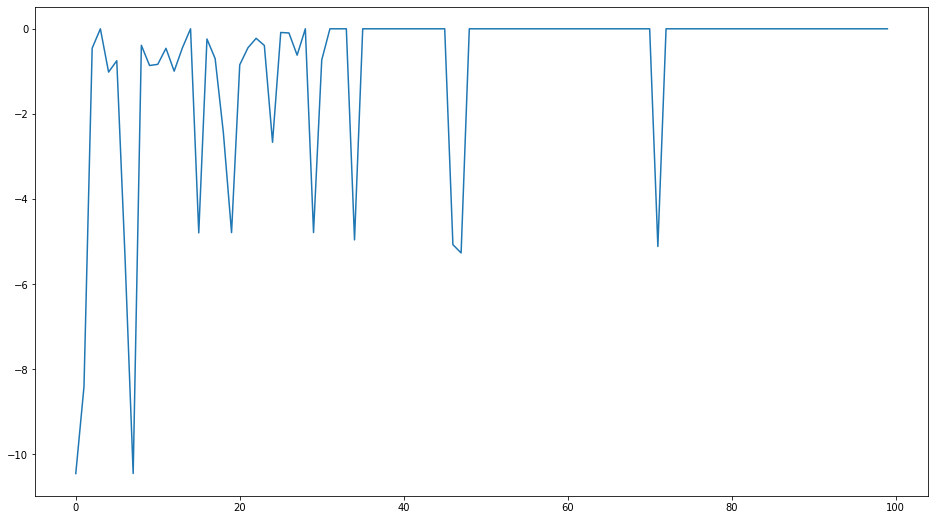

In [15]:
plt.plot(np.array(errors).squeeze())

# Plot the recovered function predictions

In [16]:
pred_samples = 10

ensemble_preds = []
for i in range(pred_samples):
    
    predictions = []

    for x, y in zip(X.T, yhat):
    

        x = np.atleast_2d(x)
        arm = dts.get_arm()
        attention_new = dts.get_attention(arm)


        predictions += [model.forward(x, attention_new).squeeze()]



    ensemble_preds.append(np.array(predictions))


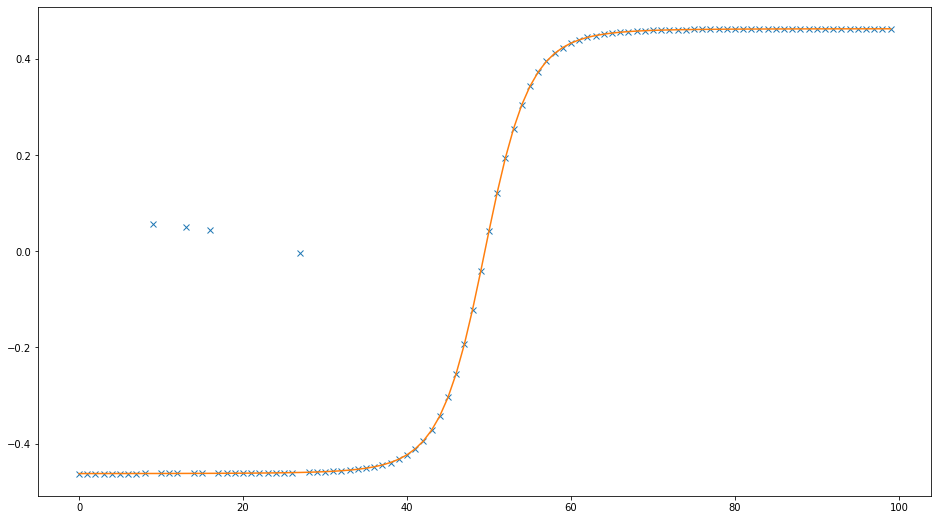

In [17]:
plt.plot(np.mean(ensemble_preds,0),'x')

plt.plot(yhat.squeeze())

# Plot the Params

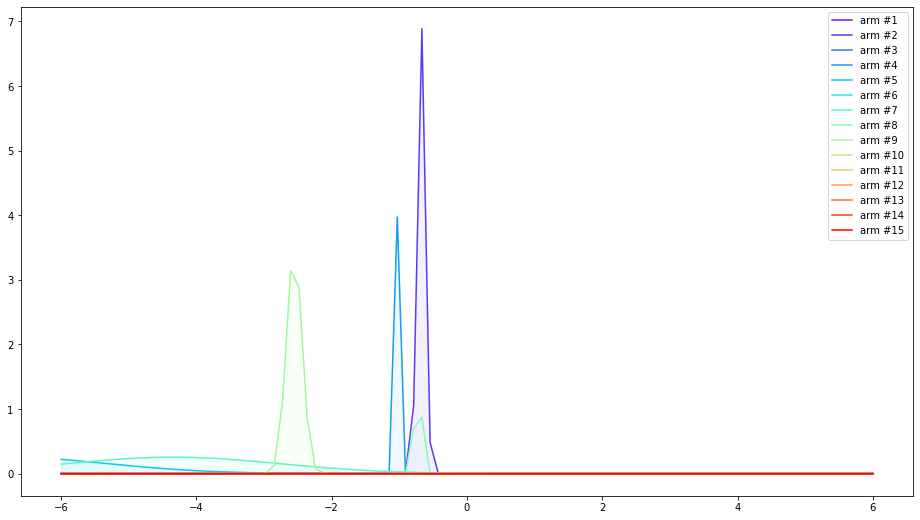

In [18]:
dts.ts.plot_params()

In [19]:
!nbdev_build_lib


Converted 00_core.ipynb.
Converted 01_thompson_sampler.ipynb.
Converted 02_neural_networks.ipynb.
Converted index.ipynb.


In [20]:
# !nbdev_build_docs